### Visualization of DOI experimets

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import zscore
import pandas as pd
from tdt import read_block, read_sev, epoc_filter 
matplotlib.rcParams['font.size'] = 18 # set font size for all figures

from bokeh.plotting import figure, show
from bokeh.io import push_notebook, output_notebook
output_notebook()

Loading BokehJS ...

In [2]:
%config Completer.use_jedi = False
%matplotlib inline

In [4]:
# CTRL_BLOCK_PATH = '/data/gergely/invivo_DATA/fiberPhotometry/dock05b-2-210224-110203/EEGCamFP2-210312-115415/'
BLOCK_PATH = '/data/gergely/invivo_DATA/fiberPhotometry/dock05b-2-210224-110203/EEGCamFP2-210312-121716/'
# ctrl_data = read_block(CTRL_BLOCK_PATH)
data = read_block(BLOCK_PATH)
# print(data)
# print('===============')
# print(data.info)

Found Synapse note file: /data/gergely/invivo_DATA/fiberPhotometry/dock05b-2-210224-110203/EEGCamFP2-210312-121716/Notes.txt
read from t=0s to t=1663.17s


In [5]:
GCAMP = '_465N' # GCaMP channel
ISOS = '_405N' # Isosbestic channel

In [6]:
npts = len(data.streams[GCAMP].data)
time_x = np.linspace(1, npts, npts) / data.streams[GCAMP].fs

In [7]:
fig1 = plt.figure(figsize=(10,6))
ax0 = fig1.add_subplot(111)
p1, = ax0.plot(time_x, data.streams[GCAMP].data, linewidth=2,
               color='green', label='GCaMP')
p2, = ax0.plot(time_x, data.streams[ISOS].data, linewidth=2,
               color='blueviolet', label='ISOS')

ax0.set_ylabel('mV')
ax0.set_xlabel('Seconds')
ax0.set_title('Raw Demodulated Responses')
ax0.legend(handles=[p1,p2], loc='upper right')
fig1.tight_layout()

Artifact Removal
There is often a large artifact on the onset of LEDs turning on
Remove data below a set time t


In [8]:
t = 8
inds = np.where(time_x > t)
ind = inds[0][0]
time_x = time_x[ind:] # go from ind to final index
data.streams[GCAMP].data = data.streams[GCAMP].data[ind:]
data.streams[ISOS].data = data.streams[ISOS].data[ind:]

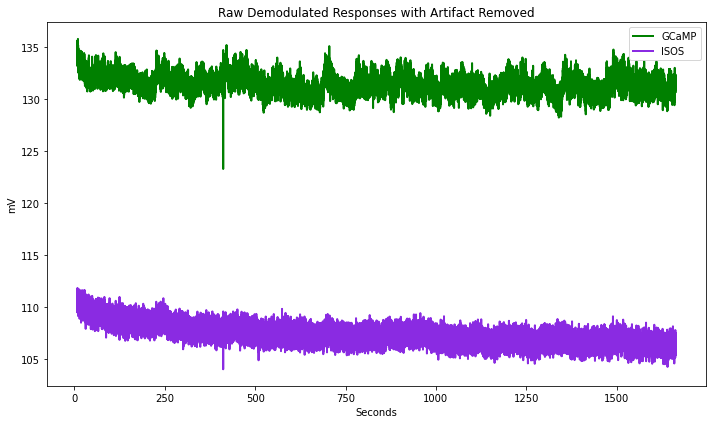

In [9]:
fig2 = plt.figure(figsize=(10, 6))
ax1 = fig2.add_subplot(111)
p1, = ax1.plot(time_x, data.streams[GCAMP].data, linewidth=2,
               color='green', label='GCaMP')
p2, = ax1.plot(time_x, data.streams[ISOS].data, linewidth=2,
               color='blueviolet', label='ISOS')

ax1.set_ylabel('mV')
ax1.set_xlabel('Seconds')
ax1.set_title('Raw Demodulated Responses with Artifact Removed')
ax1.legend(handles=[p1,p2],loc='upper right')
fig2.tight_layout()

<b>Downsample Data Doing Local Averaging</b><br>

Average around every Nth point and downsample Nx

In [10]:
N = 10 # Average every 10 samples into 1 value
F405 = []
F465 = []

for i in range(0, len(data.streams[GCAMP].data), N):
    # This is the moving window mean
    mean_wnd = np.mean(data.streams[GCAMP].data[i:i+N-1])
    F465.append(mean_wnd)

data.streams[GCAMP].data = F465

for i in range(0, len(data.streams[ISOS].data), N):
    F405.append(np.mean(data.streams[ISOS].data[i:i+N-1]))
    
data.streams[ISOS].data = F405

Decimate time array to match length of demodulated stream

In [11]:
time_x = time_x[::N] # go from beginning to end of array in steps on N
time_x = time_x[:len(data.streams[GCAMP].data)]

<b>Detrending and dFF</b><br>
Full trace dFF according to Lerner et al. 2015<br>
dFF using 405 fit as baseline

In [12]:
x = np.array(data.streams[ISOS].data)
y = np.array(data.streams[GCAMP].data)
bls = np.polyfit(x, y, 1)
Y_fit_all = np.multiply(bls[0], x) + bls[1]
Y_dF_all = y - Y_fit_all

dFF = np.multiply(100, np.divide(Y_dF_all, Y_fit_all))
std_dFF = np.std(dFF)

/home/gergely/.virtualenvs/photometry/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3343: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


In [13]:
fig3 = plt.figure(figsize=(20,12))
ax2 = fig3.add_subplot(311)

p1, = ax2.plot(time_x, dFF, linewidth=2,
               color='green', label='iGluSnfr')
# p2, = ax2.plot(LICK_x, y_scale*LICK_y+y_shift, linewidth=2,
#                color='dodgerblue', label='Lick Event')
ax2.set_ylabel(r'$\Delta$F/F')
ax2.set_xlabel('Seconds')
# ax2.set_title('dFF with Lick Epocs')
ax2.legend(handles=[p1,p2], loc='upper right')
fig3.tight_layout()

In [14]:
zscored = zscore(dFF)

In [15]:
# create a new plot with a title and axis labels
p = figure(title="Simple line example", x_axis_label='seconds',
           y_axis_label=r'dF/F')
# add a line renderer with legend and line thickness to the plot
p.line(time_x, dFF, legend_label="iGluSnFR", line_width=1, color='green')

GlyphRenderer(id='1039', ...)

In [16]:
# create a new plot with a title and axis labels
p = figure(title="Simple line example", x_axis_label='seconds',
           y_axis_label=r'dF/F')
# add a line renderer with legend and line thickness to the plot
p.line(time_x, zscored, legend_label="zscore", line_width=1, color='green')
p.line(time_x, dFF, legend_label="iGluSnFR", line_width=1, color='red', alpha=.5)

GlyphRenderer(id='1108', ...)

In [16]:
show(p)

### Loading behavior

In [17]:
beh_data_loc = ('/data/gergely/invivo_DATA/fiberPhotometry/boris_data/')
beh_data = pd.read_csv(beh_data_loc+'doi02.csv', header=15)
beh_data.head(4)

Time                                    Media file path  Total length  \
0  2.326  Y:/gergely/invivo_DATA/fiberPhotometry/dock05b...        1663.3   
1  5.475  Y:/gergely/invivo_DATA/fiberPhotometry/dock05b...        1663.3   
2  6.251  Y:/gergely/invivo_DATA/fiberPhotometry/dock05b...        1663.3   
3  7.301  Y:/gergely/invivo_DATA/fiberPhotometry/dock05b...        1663.3   

    FPS    Subject Behavior  Behavioral category  Comment Status  
0  10.0  dock05b-2  leaning                  NaN      NaN  START  
1  10.0  dock05b-2  leaning                  NaN      NaN   STOP  
2  10.0  dock05b-2  leaning                  NaN      NaN  START  
3  10.0  dock05b-2  leaning                  NaN      NaN   STOP

In [55]:
# checking if the behavior data is indeed belonging to the imaging -- WIP
data_date = pd.read_csv(beh_data_loc+'ctrl01.csv', names=["Media file path"])
data_date

Media file path
Observation id ctrl01                                             NaN      NaN  NaN       NaN     NaN NaN             NaN
NaN            NaN                                                NaN      NaN  NaN       NaN     NaN NaN             NaN
Media file(s)  NaN                                                NaN      NaN  NaN       NaN     NaN NaN             NaN
NaN            NaN                                                NaN      NaN  NaN       NaN     NaN NaN             NaN
Player #1      Y:/gergely/invivo_DATA/fiberPhotometry/dock05b-... NaN      NaN  NaN       NaN     NaN NaN             NaN
...                                                                                                                   ...
1657.279       Y:/gergely/invivo_DATA/fiberPhotometry/dock05b-... 1692.200 10.0 dock05b-1 moving  NaN NaN            STOP
1659.375       Y:/gergely/invivo_DATA/fiberPhotometry/dock05b-... 1692.200 10.0 dock05b-1 moving  NaN NaN           START
1659.775       Y:/gergely/invivo_DATA/fiberPhotometry/dock05b-... 1692.200 10.0 dock05b-1 moving  NaN NaN            STOP
1675.802       Y:/gergely/invivo_DATA/fiberPhotometry/dock05b-... 1692.200 10.0 dock05b-1 leaning NaN NaN           START
1676.901       Y:/gergely/invivo_DATA/fiberPhotometry/dock05b-... 1692.200 10.0 dock05b-1 leaning NaN NaN            STOP

[536 rows x 1 columns]

In [18]:
grooming_data = beh_data[beh_data['Behavior'] == 'grooming']
locomotion_data = beh_data[beh_data['Behavior'] == 'moving']
leaning_data = beh_data[beh_data['Behavior'] == 'leaning']

In [19]:
locomotion_data.head()

Time                                    Media file path  Total length  \
4    9.950  Y:/gergely/invivo_DATA/fiberPhotometry/dock05b...        1663.3   
5   10.476  Y:/gergely/invivo_DATA/fiberPhotometry/dock05b...        1663.3   
6   14.601  Y:/gergely/invivo_DATA/fiberPhotometry/dock05b...        1663.3   
7   18.979  Y:/gergely/invivo_DATA/fiberPhotometry/dock05b...        1663.3   
10  55.253  Y:/gergely/invivo_DATA/fiberPhotometry/dock05b...        1663.3   

     FPS    Subject Behavior  Behavioral category  Comment Status  
4   10.0  dock05b-2   moving                  NaN      NaN  START  
5   10.0  dock05b-2   moving                  NaN      NaN   STOP  
6   10.0  dock05b-2   moving                  NaN      NaN  START  
7   10.0  dock05b-2   moving                  NaN      NaN   STOP  
10  10.0  dock05b-2   moving                  NaN      NaN  START

In [20]:
locomoion_onset = locomotion_data[locomotion_data['Status']=='START']['Time']
locomoion_on_arr = locomoion_onset.to_numpy()
locomoion_offset = locomotion_data[locomotion_data['Status']=='STOP']['Time']
locomoion_off_arr = locomoion_offset.to_numpy()
# locomoion_on_arr

In [21]:
loco_on = locomoion_on_arr
loco_off = locomoion_off_arr
# making a data array for 
data_arr = np.ones(loco_on.shape[0])

Add the first and last time stamps to make tails on the TTL stream

In [22]:
loco_x = np.hstack([time_x[0],
                    np.kron([loco_on, loco_off], np.ones((2,1))).T.flatten(),
                    time_x[-1]])

Add zeros to beginning and end of 0,1 value array to match len of LICK_x

In [23]:
sz = len(loco_on)
dd = data_arr
loco_y = np.hstack([0,
                    np.vstack([np.zeros(sz), dd, dd, np.zeros(sz)]).T.flatten(),
                    0])

y_scale =  10 # adjust according to data needs
y_shift = -15 # scale and shift are just for asthetics

### try z-scoring the data!

In [24]:
fig3 = plt.figure(figsize=(20,12))
ax2 = fig3.add_subplot(311)

p1, = ax2.plot(time_x, dFF, linewidth=2,
               color='green', label='GCaMP')
p2, = ax2.plot(loco_x, y_scale*loco_y+y_shift, linewidth=2,
               color='dodgerblue', label='Locomotion Event')
ax2.set_ylabel(r'$\Delta$F/F')
ax2.set_xlabel('Seconds')
ax2.set_title('dFF with Lick Epocs')
ax2.legend(handles=[p1,p2], loc='upper right')
fig3.tight_layout()

In [25]:
# create a new plot with a title and axis labels
p = figure(title="Simple line example", x_axis_label='seconds',
           y_axis_label=r'dF/F')
# add a line renderer with legend and line thickness to the plot
p.line(time_x, dFF, legend_label="iGluSnFR", line_width=1, color='green')
p.line(loco_x,y_scale*loco_y+y_shift, legend_label="loco bouts",
       line_color="red", line_width=2)

GlyphRenderer(id='1178', ...)

In [26]:
show(p)